In [1]:
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mplsoccer import Pitch

from scipy import stats
from scipy.ndimage import gaussian_filter

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.svm import LinearSVC

from xgboost import cv, DMatrix, plot_importance, XGBClassifier

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

### Constants

In [2]:
# The only constants needed here are the pitch dimensions
# for length and width
pitch_length = 105
pitch_width = 68

In [3]:
# Here I am using the pitch element implemented in the mplsoccer
# library, which is convinient for easy plotting
pitch = Pitch(
    pitch_type='custom',
    pitch_length=pitch_length,
    pitch_width=pitch_width,
    line_color='lightgray',
    pitch_color='white',
    figsize=(11, 7),
    constrained_layout=False,
    tight_layout=True
)

### Functions

In [4]:
def plot_pass(df: pd.DataFrame, ax: matplotlib.axes, feature: str = '', text: str = ''):
    """
    This is a utility function that plots a pass as an arrow. It assumes the presence of
    the fields x, y, endx, and endy in the dataframe for the position, and the field
    outcome for determining the success of the pass.
    :param df: the dataframe where to take the passes
    :param ax: the matplotlib axes where the arrows will be plotted
    :param feature: if the feature is given, then only the data where that feature has
    a value of 1 will be plotted, otherwise the whole dataframe would be considered
    :param text: if the text is given, then it will be shown on top of the plot,
    otherwise the feature name will be taken as text value
    """
    if not text and not feature:
        raise ValueError()
    text = text if text else feature
    ax.text(pitch_length/2, 75, text, ha='center', va='center', fontsize=15)
    df_to_use = df[df[feature] == 1] if feature else df
    for idx, row in df_to_use.iterrows():
        color = 'green' if row.outcome else 'red'
        arrow = ax.arrow(row.x, row.y, row.endx - row.x, row.endy - row.y, color=color, head_width=1)
        ax.add_patch(arrow)
    ax.invert_yaxis()

### Read Data

In [5]:
df = pd.read_csv('pass_data.csv')
# Here we have a sample of the data
df.head()

,team_id,game_id,player_id,home_id,away_id,home_score,away_score,half,minute,second,outcome,x,y,endx,endy,hd_pass,cross,corner,throw,gk,gk_throw,fk_taken,chipped
0,0,0,0,0,1,1,1,1,0,1,1,52.500,34.000,30.765,32.844,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,1,1,0,2,1,31.080,32.844,26.880,21.828,0,0,0,0,0,0,0,0
2,0,0,2,0,1,1,1,1,0,6,1,26.145,18.360,49.455,19.040,0,0,0,0,0,0,0,0
3,0,0,3,0,1,1,1,1,0,11,1,59.430,7.684,76.440,13.124,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,1,0,14,0,79.170,21.964,102.375,27.404,0,0,0,0,0,0,0,0


The table above simply shows a sample of the dataset

In [6]:
# This gives the type of each column of the dataset
df.dtypes

team_id         int64
game_id         int64
player_id       int64
home_id         int64
away_id         int64
home_score      int64
away_score      int64
half            int64
minute          int64
second          int64
outcome         int64
x             float64
y             float64
endx          float64
endy          float64
hd_pass         int64
cross           int64
corner          int64
throw           int64
gk              int64
gk_throw        int64
fk_taken        int64
chipped         int64
dtype: object

### Clean Data

In [7]:
# Ideally, here we should have a pipeline for cleaning the data.
# To mock it, I check that a completed pass cannot end outside the pitch,
# because it should be impossible by rules. The deleted rows are not much,
# thus I consider this approach as valid
df = df[~((df.outcome) & ((df.endx > pitch_length) | (df.endy > pitch_width)))]
df.head()

,team_id,game_id,player_id,home_id,away_id,home_score,away_score,half,minute,second,outcome,x,y,endx,endy,hd_pass,cross,corner,throw,gk,gk_throw,fk_taken,chipped
0,0,0,0,0,1,1,1,1,0,1,1,52.500,34.000,30.765,32.844,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,1,1,0,2,1,31.080,32.844,26.880,21.828,0,0,0,0,0,0,0,0
2,0,0,2,0,1,1,1,1,0,6,1,26.145,18.360,49.455,19.040,0,0,0,0,0,0,0,0
3,0,0,3,0,1,1,1,1,0,11,1,59.430,7.684,76.440,13.124,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,1,0,14,0,79.170,21.964,102.375,27.404,0,0,0,0,0,0,0,0


In [8]:
# Another issue is that we have two rows with null values
# I simply remove them and double check that now the dataset is "clean"
df = df.dropna()
df.isna().sum()

team_id       0
game_id       0
player_id     0
home_id       0
away_id       0
home_score    0
away_score    0
half          0
minute        0
second        0
outcome       0
x             0
y             0
endx          0
endy          0
hd_pass       0
cross         0
corner        0
throw         0
gk            0
gk_throw      0
fk_taken      0
chipped       0
dtype: int64

### Add features

In [9]:
# The model should consider the already existant features
# but some extra could be considered

# For example the length of a pass is an important factor to determine
# the success of a pass. Hence, I compute the Euclidean distance
# between the start and the end point.
df['distance'] = np.sqrt((df.x - df.endx) ** 2 + (df.y - df.endy) ** 2)

# Another feature that could be considered is the angle of the pass.
# I assume that 0 angle means a forward pass, which means that an angle > 90
# is a backward pass. To compute it, I use the cosine Theorem.
df['c'] = np.sqrt((df.endy - df.y) ** 2 + (df.endx - pitch_length) ** 2)
df['b'] = np.sqrt((df.x - pitch_length) ** 2)
df['alpha'] = (df.c ** 2 - df.b ** 2 - df.distance ** 2) / (- 2 * df.distance * df.b)
df['alpha'] = df.alpha.apply(lambda alpha: np.arccos(alpha))
df['alpha'] = df.alpha.apply(lambda alpha: np.pi + alpha if alpha < 0 else alpha)

df['angle'] = df.alpha * 180 / np.pi
df['angle'] = df.angle.fillna(180.)

df.drop(['alpha', 'b', 'c'], axis=1, inplace=True)

df.head()

,team_id,game_id,player_id,home_id,away_id,home_score,away_score,half,minute,second,outcome,x,y,endx,endy,hd_pass,cross,corner,throw,gk,gk_throw,fk_taken,chipped,distance,angle
0,0,0,0,0,1,1,1,1,0,1,1,52.500,34.000,30.765,32.844,0,0,0,0,0,0,0,0,21.765720,176.955529
1,0,0,1,0,1,1,1,1,0,2,1,31.080,32.844,26.880,21.828,0,0,0,0,0,0,0,0,11.789498,110.870029
2,0,0,2,0,1,1,1,1,0,6,1,26.145,18.360,49.455,19.040,0,0,0,0,0,0,0,0,23.319916,1.670960
3,0,0,3,0,1,1,1,1,0,11,1,59.430,7.684,76.440,13.124,0,0,0,0,0,0,0,0,17.858715,17.734894
4,0,0,0,0,1,1,1,1,0,14,0,79.170,21.964,102.375,27.404,0,0,0,0,0,0,0,0,23.834127,13.193719


### Sample Plots

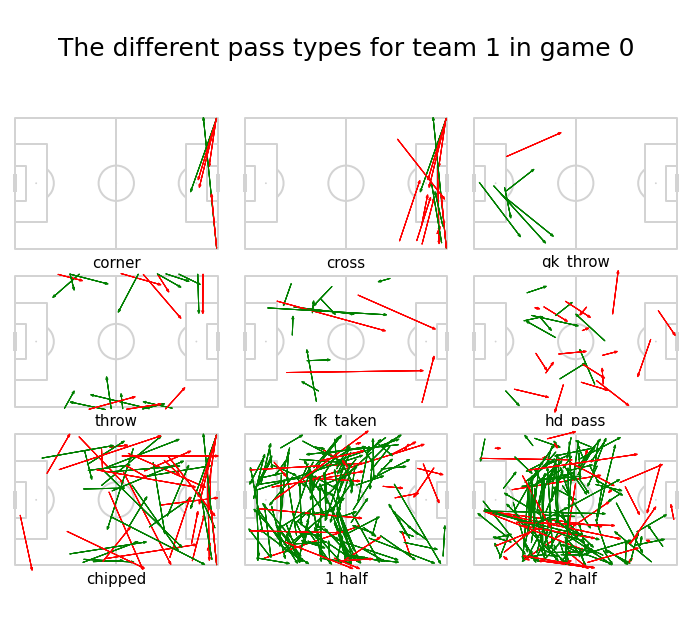

In [10]:
# Now, to start exploring the data and the features, I plot the passes by types

# Filter data for only one game of a team to get a sample
game_id = 0
team_id = 1
df_test = df[(df.game_id == game_id) & (df.team_id == team_id)]

fig, axs = pitch.grid(nrows=3, ncols=3, axis=False)

# Invert the axis because attacking left is coordinate y = 0

title = axs['title'].text(
    0.5, 0.5, f'The different pass types for team {team_id} in game {game_id}', ha='center', fontsize=25
)
# Let's invoke the utility function defined just below the imports
plot_pass(df_test, feature='corner', ax=axs['pitch'][0][0])
plot_pass(df_test, feature='cross', ax=axs['pitch'][0][1])
plot_pass(df_test, feature='gk_throw', ax=axs['pitch'][0][2])
plot_pass(df_test, feature='throw', ax=axs['pitch'][1][0])
plot_pass(df_test, feature='fk_taken', ax=axs['pitch'][1][1])
plot_pass(df_test, feature='hd_pass', ax=axs['pitch'][1][2])
plot_pass(df_test, feature='chipped', ax=axs['pitch'][2][0])

# To show just the base passes which do not belong to any pass type already defined,
# I filter the elements and plot them
df_simple_pass = df_test[
    (df_test.corner == 0) &
    (df_test.cross == 0) &
    (df_test.gk_throw == 0) &
    (df_test.throw == 0) &
    (df_test.fk_taken == 0) &
    (df_test.hd_pass == 0) &
    (df_test.chipped == 0)
]
for half in [1, 2]:
    plot_pass(df_simple_pass[df_simple_pass.half == half], text=f'{half} half', ax=axs['pitch'][2][half])

The plot above shows for a single team in a single match the different features available in the dataset.
In the top-left, we see the corners played by team 1 during the whole match (game 0).
Middle-top shows crosses of the same team and game. We see that some corners are considered as crosses.
Then, the top-right displays the goalkeeper's throw-ins.
Center-left we have the throws in. These values could have been deleted from the data frame, because this
kind of pass is a bit different from the others.
In the middle, there are the free-kicks gained by the team. Some may be considered crosses too, it depends
on how it is performed.
In the middle-right we have the head passes, and we see that their performance is a bit lower, just by looking
at the plot.
In the bottom-left, we find the chipped passes, which could also be considered as crosses.
Then, in the middle-bottom and bottom-right, I summarized the passes for each half of the analyzed game.
It is possible to see a different pattern, while in the second half the barycenter of the team is higher.

Text(0.5, 1.0, 'Passes by angle')

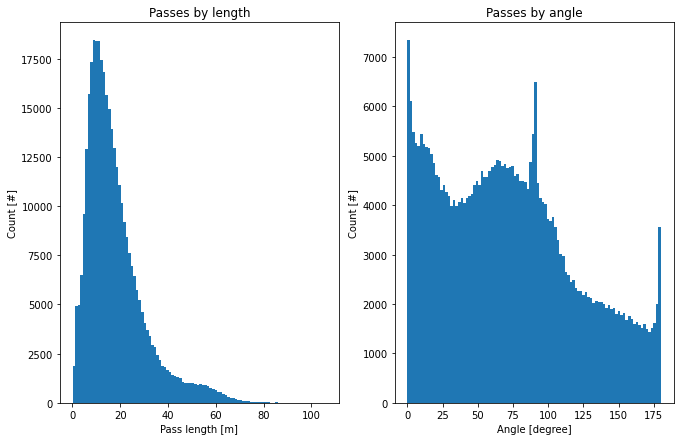

In [11]:
# Plot the distributions of the passes by distance and angle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))
ax1.hist(df.distance, bins=100)
ax1.set_xlabel('Pass length [m]')
ax1.set_ylabel('Count [#]')
ax1.set_title('Passes by length')

ax2.hist(df.angle, bins=100)
ax2.set_xlabel('Angle [degree]')
ax2.set_ylabel('Count [#]')
ax2.set_title('Passes by angle')

Here above we see the distribution of the two features I computed.
On the left, we have the pass length and the count on the y axis. We see that the high majority
of the passes is pretty short (less than 20 m), and meanwhile, we increase the length of the pass
the number of passes of that type dramatically decreases.
On the right instead, we have on the x-axis the angle (where 0 means forward and 180 means backward,
and the two halves are mirrored, which means that a pass on the right or on the left has the same angle),
and on the y axis, we still have the count. It is possible to see that we have a lot of forwarding passes and passes
that go to the right or left,  while the number of backward passes (more than 90 degrees) decreases with respect to the passes that end up in a place with a higher x coordinate (i.e., a forward pass).

<ipython-input-12-7bebdb720d03>:9: RuntimeWarning: invalid value encountered in true_divide
  prob_pass_dist = np.divide(success_pass_dist[0], pass_dist[0])


Text(0.5, 1.0, 'Passes by angle')

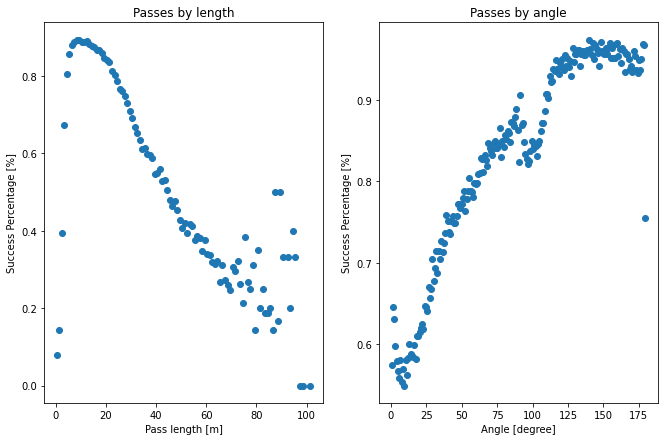

In [12]:
# Plot the distributions of the passes by success rate wrt the distance and the angle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))

# Since the amount of passes is too high, let's summarize it through an histogram
# Compute the statistics for passes and successful passes with respect to their length,
# and plot their relationship
pass_dist = np.histogram(df.distance, bins=105, range=[0, 105])
success_pass_dist = np.histogram(df[df.outcome == 1].distance, bins=105, range=[0, 105])
prob_pass_dist = np.divide(success_pass_dist[0], pass_dist[0])
distance = pass_dist[1]
mid_distance = (distance[:-1] + distance[1:]) / 2

ax1.scatter(mid_distance, prob_pass_dist)
ax1.set_xlabel('Pass length [m]')
ax1.set_ylabel('Success Percentage [%]')
ax1.set_title('Passes by length')


# As it happened earlier, since the amount of passes is too high, let's summarize
# it through an histogram
# Compute the statistics for passes and successful passes with respect to their angle,
# and plot their relationship
pass_angle = np.histogram(df.angle, bins=200, range=[0, 180])
success_pass_angle = np.histogram(df[df.outcome == 1].angle, bins=200, range=[0, 180])
prob_pass_angle = np.divide(success_pass_angle[0], pass_angle[0])
angle = pass_angle[1]
mid_angle = (angle[:-1] + angle[1:]) / 2

ax2.scatter(mid_angle, prob_pass_angle)
ax2.set_xlabel('Angle [degree]')
ax2.set_ylabel('Success Percentage [%]')
ax2.set_title('Passes by angle')

# The plot shows that by increasing the length of the pass, the success rate
# decreases. There are some outliers when the length is above 70 meters, where the success
# rate increases again. Those are mainly goalkeeper passes made from the box.
# For what concerns the angle instead, we see that the probability is above 90 % when we
# have a backward pass. On the other side, intuitively a forward pass pass has a lower succes rate.

The plots above show the pass length with respect to the success rate of the passes and on the right
the same analysis but for the angle of the pass.
For what concerns the path length, we saw above that we have a lot of short passes, which are also those
that have the highest success rate, while by increasing the pass length we decrease both the success rate and the number of long passes.
On the right instead, we have the opposite situation for the angles. Forward passes have a lower success rate,
but those are pretty common in the dataset. While we increase the angle of the pass with respect to the forward
direction (i.e., as much as we move the pass backward), the success rate increases, but the number of passes decreases.
It is pretty interesting to see the almost opposite behavior of those two features.
However, while for what concerns the angle, with a forward pass we still have 60% of the chances for a successful pass, for longer passes (close to 100 m) the success rate is around 20%, which is a very low value.

### Pass Distribution

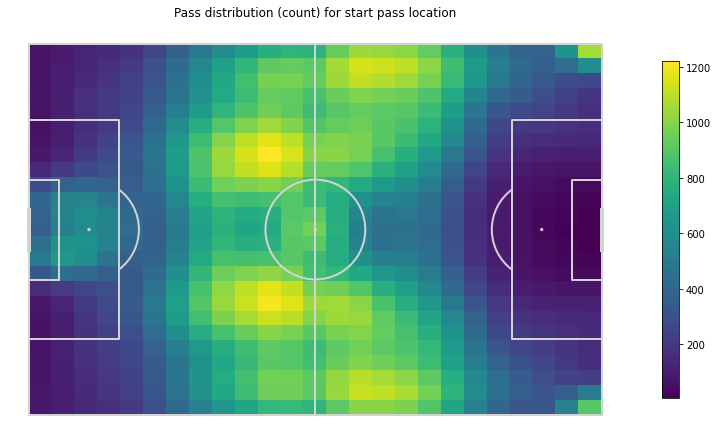

In [13]:
fig, ax = pitch.draw(figsize=(11, 7))

plt.gca().invert_yaxis()

# To plot the pass distribution, I divide the starting points in bins
# and compute the statistics over the bins
statistic, x_edge, y_edge, _ = stats.binned_statistic_2d(
    df.x, df.y, None, statistic='count', bins=(25, 25), range=[[0, pitch_length], [0, pitch_width]]
)

statistic = statistic.T
# I apply gaussian filtering to reduce the noise
statistic = gaussian_filter(statistic, 1)

x_grid, y_grid = np.meshgrid(x_edge, y_edge)

mesh = ax.pcolormesh(x_grid, y_grid, statistic, zorder=-1)
ax.set_title('Pass distribution (count) for start pass location')
fig.colorbar(mesh, ax=ax, shrink=0.7)

Here above we see a field map, where the most used starting point for a pass is the central area (for the x axis),
and in particular (if we split the field vertically in 5 portions, where 1 is the left part and 5 is the right one) the passes start mainly from zones 2 and 4, and then we have the lateral corridors (zone 1 and 5).

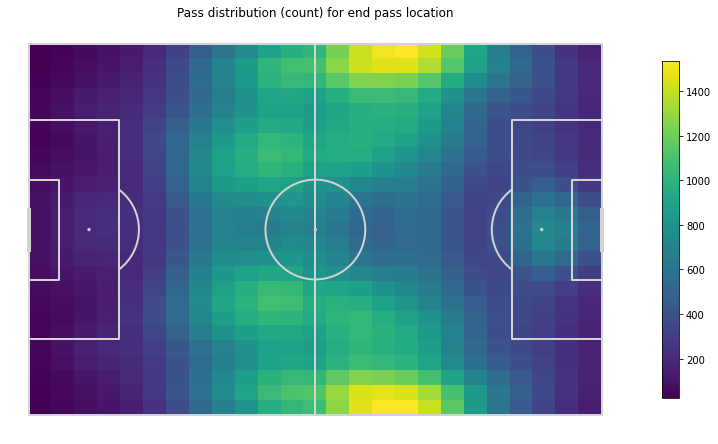

In [14]:
fig, ax = pitch.draw(figsize=(11, 7))

plt.gca().invert_yaxis()

# To plot the pass distribution, I divide the ending points in bins
# and compute the statistics over the bins
statistic, x_edge, y_edge, _ = stats.binned_statistic_2d(
    df.endx, df.endy, None, statistic='count', bins=(25, 25), range=[[0, pitch_length], [0, pitch_width]]
)
statistic = statistic.T
# I apply gaussian filtering to reduce the noise
statistic = gaussian_filter(statistic, 1)

x_grid, y_grid = np.meshgrid(x_edge, y_edge)

mesh = ax.pcolormesh(x_grid, y_grid, statistic, zorder=-1)
ax.set_title('Pass distribution (count) for end pass location')
fig.colorbar(mesh, ax=ax, shrink=0.7)

Here instead we have the final position of the passes. If in the whole starting positions the central area is covered, for what concerns the final position the most used one is the lateral corridor in the opposite half of the field.

### Expected Pass Model

In [15]:
# For the model, I will provide as feature the information about the pass start and end position,
# the type of pass, given by the extra columns in the dataset, and the new feature I computed
# Of course here it should be done a feature engineering work to determine what else can be added
# or if something could be removed.

# Moreover, maybe not all the data should be considered. For example, throw in are a specific kind
# of pass, and an improvement of the model would just remove them from the data.

position_cols = ['x', 'y', 'endx', 'endy']
pass_types_cols = ['hd_pass', 'cross', 'corner', 'throw', 'gk', 'gk_throw', 'fk_taken', 'chipped']
added_features_cols = ['distance', 'angle']

X = df[position_cols + pass_types_cols + added_features_cols]
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=0, stratify=y
)

In [16]:
# To understand which is the best model to use, I consider 4 variants:
# logistic regression, random forest classifier, xgboost classifier, and svm.
# Then, I will use cross validation for all the models to see how they perform
# and if the data are split erroneously. After that, I train again the models
# over the full train dataset and will evaluate it with the test dataset.

# I use the AUC because it is a common and extensively used metric in the field,
# and properly grasps the performance of the model.

models = {
    'logistic_regression': LogisticRegression(random_state=0),
    'random_forest_classifier': RandomForestClassifier(random_state=0),
    'xgboost_classifier': XGBClassifier(random_state=0, eval_metric='auc'),
    'svm': LinearSVC(random_state=0)
}

trained_models = {}
for alg_name, alg in models.items():
    print(alg_name)
    if 'xgboost' not in alg_name:
        c_v = KFold(n_splits=3, random_state=0, shuffle=True)
        print(f'\tcross-validation: {cross_val_score(alg, X_train, y_train, cv=c_v)}')
    else:
        c_v = cv(dtrain=DMatrix(data=X_train, label=y_train), params={}, metrics='auc', nfold=3, seed=0)
        print(f'\tcross-validation: {list(c_v["test-auc-mean"].iloc[-3:])}')
    model = alg.fit(X_train, y_train)
    trained_models[alg_name] = model
    y_pred = model.predict(X_test)
    y_pred = y_pred > 0.5
    print(f'\taccuracy: {accuracy_score(y_test, y_pred)}')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f'\tconfusion_matrix:\tTP: {tp} - TN: {tn} - FP: {fp} - FN: {fn}')
    print(f'\troc_auc: {roc_auc_score(y_test, y_pred)}')

logistic_regression
	cross-validation: [0.83874744 0.83953508 0.83363994]
	accuracy: 0.839129677374399
	confusion_matrix:	TP: 215208 - TN: 25639 - FP: 34142 - FN: 12031
	roc_auc: 0.6879689146769332
random_forest_classifier
	cross-validation: [0.87047954 0.87252279 0.86984698]
	accuracy: 0.873217894223399
	confusion_matrix:	TP: 213441 - TN: 37190 - FP: 22591 - FN: 13798
	roc_auc: 0.7806919010507093
xgboost_classifier
	cross-validation: [0.90611, 0.9068, 0.908486]
	accuracy: 0.8769214688871856
	confusion_matrix:	TP: 214175 - TN: 37519 - FP: 22262 - FN: 13064
	roc_auc: 0.7850586511322585
svm
	cross-validation: [0.80831138 0.75641776 0.7500209 ]
	accuracy: 0.8324890251550414
	confusion_matrix:	TP: 216456 - TN: 22485 - FP: 37296 - FN: 10783
	roc_auc: 0.664335303241974


Cross-validation shows that the data are not biased and there is no overfitting problem. So, we can see how they perform. In the literature, one of the most used evaluation metrics is ROC AUC and by ranking the different models we have in the first position XGBoost Classifier. If we would have been in a different setting, we would have considered another metric. For example, if our scenario would have been to minimize the risk and being safer by raising an alert for every error, we would have chosen to minimize the false negatives, thus selecting SVM.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

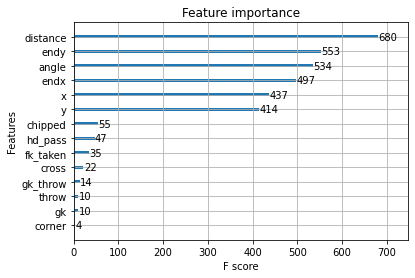

In [17]:
# The best model is XGBoostClassifier according to the metric we defined, AUC.
# Instead, if for example we would have prefered to minimize the false negatives,
# then the choice would be SVM, which has the lowest value for that metric.
model = trained_models['xgboost_classifier']

# Let's now use the xgboost tool to plot the feature importance for the model we
# are using.
plot_importance(model)

Above we have the feature importance. For the model, I developed I use all the features, but probably using only distance, angle, start and end position would have been enough.

In [18]:
# Let's get the predictions from the model for the whole dataset and add a new column
# to the dataframe.
# Here I am considering the whole dataset and even the data I used for training the model
# just as a showcase, to have more data for the next parts

y_pred = model.predict(X)
df['prediction'] = y_pred
df.head()

,team_id,game_id,player_id,home_id,away_id,home_score,away_score,half,minute,second,outcome,x,y,endx,endy,hd_pass,cross,corner,throw,gk,gk_throw,fk_taken,chipped,distance,angle,prediction
0,0,0,0,0,1,1,1,1,0,1,1,52.500,34.000,30.765,32.844,0,0,0,0,0,0,0,0,21.765720,176.955529,1
1,0,0,1,0,1,1,1,1,0,2,1,31.080,32.844,26.880,21.828,0,0,0,0,0,0,0,0,11.789498,110.870029,1
2,0,0,2,0,1,1,1,1,0,6,1,26.145,18.360,49.455,19.040,0,0,0,0,0,0,0,0,23.319916,1.670960,1
3,0,0,3,0,1,1,1,1,0,11,1,59.430,7.684,76.440,13.124,0,0,0,0,0,0,0,0,17.858715,17.734894,1
4,0,0,0,0,1,1,1,1,0,14,0,79.170,21.964,102.375,27.404,0,0,0,0,0,0,0,0,23.834127,13.193719,0


### How difficulty changes over the area

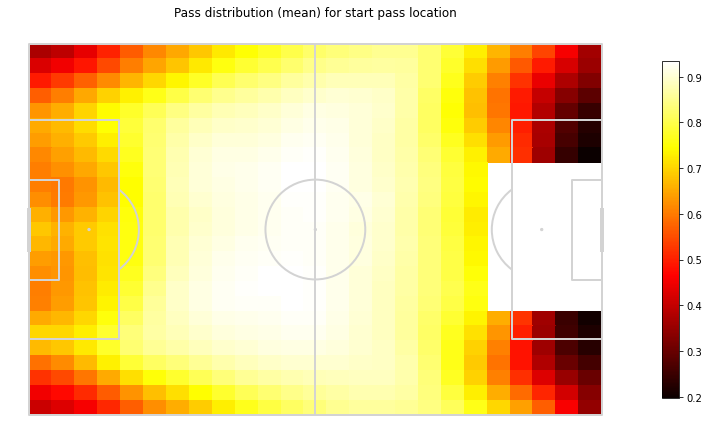

In [19]:
fig, ax = pitch.draw(figsize=(11, 7))

plt.gca().invert_yaxis()

# Here we use again the binned_statistic_2d function to find how the difficulty
# of a pass changes over the pitch for the start location
statistic, x_edge, y_edge, _ = stats.binned_statistic_2d(
    df.x, df.y, df.prediction, statistic='mean', bins=(25, 25), range=[[0, pitch_length], [0, pitch_width]]
)

statistic = statistic.T
# Again, I apply gaussian filtering to reduce the noise
statistic = gaussian_filter(statistic, 1)

x_grid, y_grid = np.meshgrid(x_edge, y_edge)

mesh = ax.pcolormesh(x_grid, y_grid, statistic, cmap='hot', zorder=-1)
ax.set_title('Pass distribution (mean) for start pass location')
fig.colorbar(mesh, ax=ax, shrink=0.7)

# The opposite box is white expecially because of the low number of passes
# that start from that region

The figure above shows the success rate of a pass knowing where it starts.
As expected, we see that it is hard to handle the ball in the opposite box.

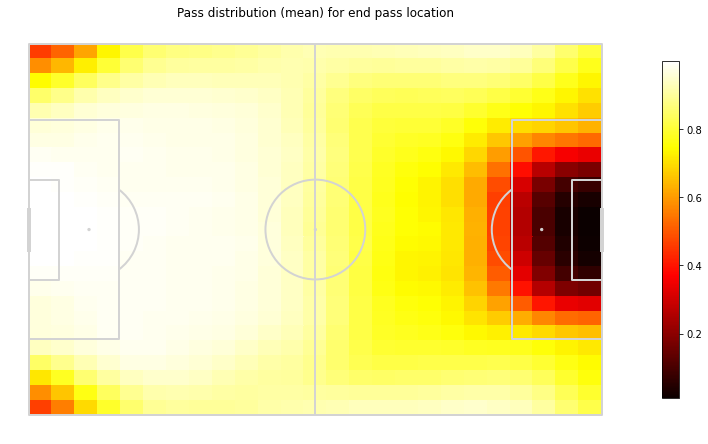

In [20]:
fig, ax = pitch.draw(figsize=(11, 7))

plt.gca().invert_yaxis()

# Here we use again the binned_statistic_2d function to find how the difficulty
# of a pass changes over the pitch for the end location
statistic, x_edge, y_edge, _ = stats.binned_statistic_2d(
    df.endx, df.endy, df.prediction, statistic='mean', bins=(25, 25), range=[[0, pitch_length], [0, pitch_width]]
)

statistic = statistic.T
# Again, I apply gaussian filtering to reduce the noise
statistic = gaussian_filter(statistic, 1)

x_grid, y_grid = np.meshgrid(x_edge, y_edge)

mesh = ax.pcolormesh(x_grid, y_grid, statistic, cmap='hot', zorder=-1)
ax.set_title('Pass distribution (mean) for end pass location')
fig.colorbar(mesh, ax=ax, shrink=0.7)

Finally, we can compare this image about the ending position of the passes with the previous one, which was about the starting position of the passes. Again, as expected, the red area, which means the area where the passes are less prone to be successful, is in the opposite box. Here we see how hard is to receive the ball there with respect for example to the regions next to the corners. Instead, in the previous plot, these regions were red because there start all the crosses, which have a very low success rate. Hence, the plot shows the differences in the success rates through the field. It should be instead further analyzed the red areas next to the defensive corner spots (on the left). Intuition is that this could be due to the low amount of passes there.

### Players skills

In [21]:
# Now, we should find groups of similar players based on their passing style
# and determine who are the best passers

# Let's create a new dataframe with the data we are interested
df_players = df.groupby(['player_id', 'team_id']).agg({
    'outcome': ['count', 'sum'],
    'prediction': ['count', 'sum'],
    "game_id": pd.Series.nunique,
    "distance": 'mean'
})

df_players['passes'] = df_players['outcome']['count']
df_players['games'] = df_players['game_id']['nunique']
df_players['avg_distance'] = df_players['distance']['mean']
df_players['pass_probability'] = df_players['outcome']['sum'] / df_players['outcome']['count']
df_players['xP_rate'] = df_players['outcome']['sum'] / df_players['prediction']['sum']
df_players['expected_probability'] = df_players['prediction']['sum'] / df_players['prediction']['count']
df_players['pass_by_game'] = df_players['prediction']['sum'] / df_players['passes']

df_players = df_players.drop(columns=['outcome', 'prediction', 'game_id', 'distance']).reset_index()

df_players.head()

,player_id,team_id,passes,games,avg_distance,pass_probability,xP_rate,expected_probability,pass_by_game
,,,,,,,,,
0,0,0,115,9,12.956891,0.713043,0.942529,0.756522,0.756522
1,1,0,102,7,18.460047,0.794118,0.987805,0.803922,0.803922
2,2,0,651,18,19.800425,0.814132,0.960145,0.847926,0.847926
3,3,0,91,7,15.759391,0.648352,0.907692,0.714286,0.714286
4,4,1,561,24,40.451735,0.661319,1.228477,0.538324,0.538324


Here the passes are grouped by players, adding columns for some statistics, such as the number of passes across the season, the number of games, average length of the pass, the percentage of successful passes by a player, and adding the output of the model used above, to measure the expected pass rate and the expected probability. All these methods could be used to rank the players and find the best passer, it depends on the KPIs we want to optimize.

In [22]:
# Filter only the players with at least 500 passes in a league to avoid noisy data
df_players_filtered = df_players[df_players.passes > 500]

# To define the best passers, we may define several metrics, it depends on what we are
# interested to: average length, # forward passes per game, # xP ratio, # passes per game,
# lower expected probability (means that it tries harder passes), and many others.

# Here the players are sorted by expected pass rate, which is the ratio between
# the completed passes and the expected passes, which means that the higher the better
df_players_filtered.sort_values('xP_rate', ascending=False).head()

,player_id,team_id,passes,games,avg_distance,pass_probability,xP_rate,expected_probability,pass_by_game
,,,,,,,,,
481,464,3,707,28,44.480364,0.589816,1.275229,0.462518,0.462518
181,177,13,513,23,45.638001,0.612086,1.231373,0.497076,0.497076
4,4,1,561,24,40.451735,0.661319,1.228477,0.538324,0.538324
42,42,2,1113,38,48.822653,0.560647,1.221135,0.459119,0.459119
305,296,5,563,26,46.424859,0.573712,1.209738,0.474245,0.474245


Above, we have the players sorted by expected pass rate, which is:
 number of successful passes / number of expected successful passes
(the higher the better)

In [23]:
# Here the players are sorted by pass probability, which is the percentage of
# completed passes, which means that the higher the better
df_players_filtered.sort_values('pass_probability', ascending=False).head()

,player_id,team_id,passes,games,avg_distance,pass_probability,xP_rate,expected_probability,pass_by_game
,,,,,,,,,
198,194,14,1749,35,19.770730,0.943396,0.990396,0.952544,0.952544
671,650,15,622,7,15.103990,0.942122,0.978297,0.963023,0.963023
210,206,15,1900,21,17.433873,0.927368,0.978345,0.947895,0.947895
222,217,15,578,12,15.594501,0.920415,0.974359,0.944637,0.944637
325,315,18,1589,28,16.848297,0.918817,0.963696,0.953430,0.953430


Above, we have the players sorted by pass probability, which is:
 number of passes / number of total passes attempted
(the higher the better)

In [24]:
# Here the players are sorted by expected probability, which is the percentage of
# expected passes to be completed over the number of tried passes, also here the higher the better
df_players_filtered.sort_values('expected_probability', ascending=False).head()

,player_id,team_id,passes,games,avg_distance,pass_probability,xP_rate,expected_probability,pass_by_game
,,,,,,,,,
671,650,15,622,7,15.103990,0.942122,0.978297,0.963023,0.963023
325,315,18,1589,28,16.848297,0.918817,0.963696,0.953430,0.953430
198,194,14,1749,35,19.770730,0.943396,0.990396,0.952544,0.952544
210,206,15,1900,21,17.433873,0.927368,0.978345,0.947895,0.947895
227,222,16,1350,22,14.435641,0.908148,0.959311,0.946667,0.946667


Above, we have the players sorted by expected probability, which is:
 number of expected successful passes / number of total passes attempted
(the higher the better)

Text(1.1, 0.9, 'Hard passes - Good performance')

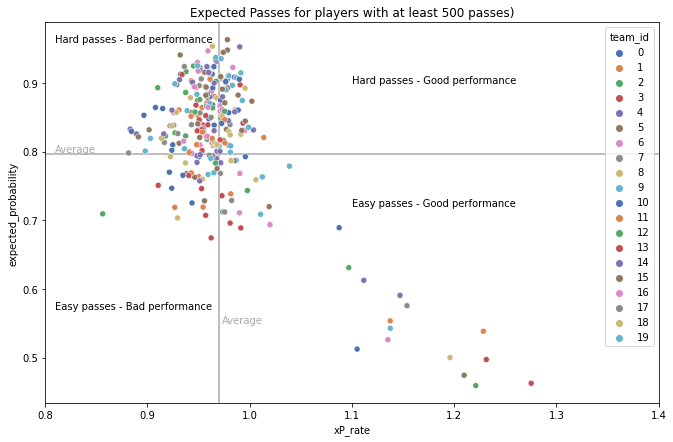

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))

ax = sns.scatterplot(data=df_players_filtered, x='xP_rate', y='expected_probability', hue='team_id', palette="deep", legend='brief')

# We don't print the player id for clearness purposes
# for idx, row in df_players_filtered.iterrows():
#     ax.text(x=row.xP_rate + 0.002, y=row.pass_probability, s=f'{int(row.player_id[0])}', zorder=-1)

# Add lines for the average of the two axes
avg_xp_rate = df_players_filtered.xP_rate.mean()
avg_pass_prob = df_players_filtered.pass_probability.mean()
ax.axvline(x=avg_xp_rate, ymin=0, color='darkgray', zorder=-2)
ax.text(x=avg_xp_rate + 0.003, y=0.55, s='Average', color='darkgray')
ax.axhline(y=avg_pass_prob, xmin=0, color='darkgray', zorder=-2)
ax.text(x=0.81, y=avg_pass_prob + 0.003, s='Average', color='darkgray')

plt.xlim(0.8, 1.4)

plt.title(f"Expected Passes for players with at least 500 passes)")          

# Add definition of the quadrants
plt.text(x=1.10, y=0.72, s="Easy passes - Good performance")
plt.text(x=0.81, y=0.57, s="Easy passes - Bad performance")
plt.text(x=0.81, y=0.96, s="Hard passes - Bad performance")
plt.text(x=1.10, y=0.90, s="Hard passes - Good performance") 

Here, we compare the players by their "Expected passes value". It means that we compare the expected pass rate (completed passes / expected completed passes) over the expected pass probability (expected passes to be completed / total passes) In the plot, the same color means the same team. The majority of the players are placed between the 1st and 2nd quadrants, which means that they are keener to attempt harder passes. Then, at the bottom right, we find some players, which focus on making safe choices by making simple passes that end up in a success rate higher than its expected value.
Thus, we have several ways to crown a player as the best passer:

Thus, we have several ways to crown a player as the best passer:
- average length
- expected pass rate (successful passes / expected successful passes)
- average number of passes by game
- success rate (successful passes / total passes attempted)
- expected success rate (expected successful passes / total passes attempted)
- and many others, depending on the KPI

### Similar Players

One way to find similar players is to use statistical measurements, for example like the ones defined above. Another option would be to use a clustering technique: in this case, of course, this is just a show-case, because other extra information would be important, as the position where each player played the game, the tactical imprint the coach gives to the team, and others.
KMeans allows (instead of DBScan) the definition of the number of the k cluster. I use 11 as it seems a reasonable number given that there are 11 players on the pitch. This approach could be used to define the player positions. As features, I am using only the start and end position (again, it would be easily extendible by adding external ones).

In [26]:
n_clusters = 11
# Usually for clustering we normalize the features.
# However, in this case the features have the same range and one does not dominate the other.
# Moreover, the resulting data will be reprouced identically by normalizing the features.
# I used z-normalization and as just said, the results are identical.
# Hence, to directly have available the coordinates to plot, I didn't normalize the input data.
clustering = KMeans(n_clusters=n_clusters).fit(X[['x', 'y', 'endx', 'endy']])
df['cluster'] = clustering.predict(X[['x', 'y', 'endx', 'endy']])

In [27]:
# This shows the number of passes in each cluster
df.cluster.value_counts()

5     45187
8     44568
3     41734
1     41421
6     41032
2     32641
7     27314
4     26962
9     23472
10    22648
0     11796
Name: cluster, dtype: int64

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'Elbow Method results')

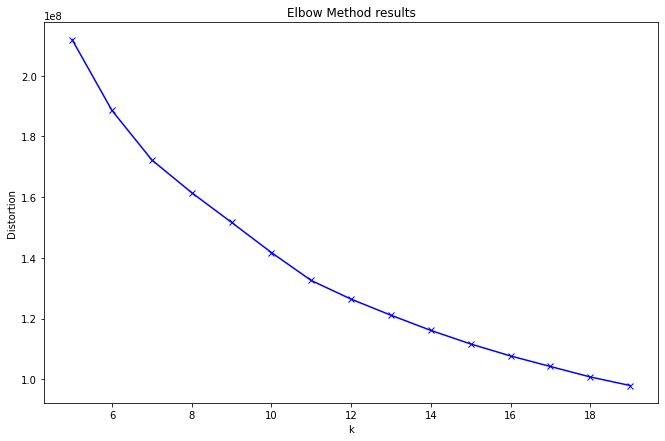

In [28]:
# This is the results obtained through the Elbow method, which should tell
# the best k to use to reduce the noise in the data and obtain reasonable results.
elbow_data = []
for k in range(5, 20):
    print(k)
    km = KMeans(n_clusters=k).fit(X[['x', 'y', 'endx', 'endy']])
    elbow_data.append(km.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(11,7))
ax.plot(list(range(5, 20)), elbow_data, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
ax.set_title('Elbow Method results')

The plot shows that the distortion is reduced by a higher number of clusters. Moreover, the distortion is still high for 11, which means there is still noise within the identified clusters. However, I decided to take 11 as a value because I want to check if with those clusters I will be able to find players that play in the same position.

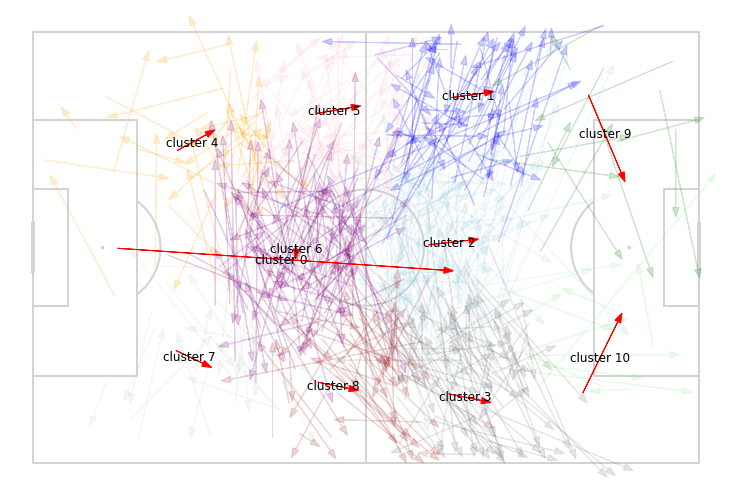

In [29]:
fig, ax = pitch.draw(figsize=(11, 7))

plt.gca().invert_yaxis()

for idx, center in enumerate(clustering.cluster_centers_):
    ax.text(
        center[0] + (center[2] - center[0]) / 2,
        center[1] + (center[3] - center[1]) / 2,
        s=f'cluster {idx}',
        zorder=5,
        ha='center',
        va='center',
        fontsize=12
    )
    arrow = ax.arrow(center[0], center[1], center[2] - center[0], center[3] - center[1], color='red', head_width=1, zorder=4)

# Here we select the player with the highest xP_rate that we found in the statistics above.
# It will have passes from several clusters, hence it will be a nice plot of the passes
# in the different clusters
df_plot = df[(df.player_id == 650)]

cluster_colors = [
    'darkgray', 'blue', 'lightblue', 'gray', 'orange', 'pink', 'purple', 'lightgray', 'brown', 'green', 'lightgreen'
]

for idx, row in df_plot.iterrows():
    color = cluster_colors[int(row.cluster)]
    arrow = ax.arrow(
        row.x, row.y, row.endx - row.x, row.endy - row.y, color=color, alpha=0.1, head_width=1, zorder=1
    )
    ax.add_patch(arrow)

The plot above is about the passes made by the player that had the highest expected pass rate from the previous analysis.

From the plot, we may guess that the player is a central midfielder that does not attack much because it has few passes in the opposite box, and also it should not be a center-back, given the fewer passes in the defensive box than those expected from a center-back, as well as few passes in the last 30 meters for what I expect from an attacking midfielder, and he covers the middle area, so it cannot be a full-back.

In [30]:
from collections import Counter

def is_in_the_cluster(values: List[int], cluster: int, percentage: int) -> bool:
    """
    Given the cluster ids of the different passes and a target cluster id,
    it checks if the passes in the target cluster are at least a specific
    percentage of the total.
    :param values: the list of cluster ids
    :param cluster: the cluster id to identify
    :param percentage: the percentage of passes that should be in the target cluster
    """
    counts = Counter(values)
    if cluster in counts:
        if counts[cluster] > sum(counts.values()) * percentage:
            return True
    return False

mask = df.groupby('player_id').cluster.transform('count') > 100
df_test = df[(mask)]
df_test = df_test.groupby('player_id').cluster
for idx in range(n_clusters):
    players = df_test.agg(is_in_the_cluster, cluster=idx, percentage=.40)
    print(f'cluster {idx} - Players: {list(players[players].index)}')
    print('=============================')

cluster 0 - Players: [4, 12, 37, 42, 58, 75, 100, 101, 128, 130, 158, 177, 197, 214, 238, 261, 296, 324, 408, 451, 464, 475, 505, 515, 523, 544, 609, 623, 655, 698]
cluster 1 - Players: []
cluster 2 - Players: []
cluster 3 - Players: [591]
cluster 4 - Players: []
cluster 5 - Players: [560]
cluster 6 - Players: []
cluster 7 - Players: []
cluster 8 - Players: [136, 470, 639]
cluster 9 - Players: []
cluster 10 - Players: []


Here, first, we check which is the percentage of passes that belong to a specific cluster.

If it is above a defined threshold, then we can consider the resulting players that result in having a high value of passes in the same cluster, to have a similar passing style. Here we should consider also that a player may have not played for the whole season in the same position. Moreover, it would be useful to filter the players with a few games and passes.

Text(0.5, 1.0, 'Passes in the different clusters for players [136, 470, 639]')

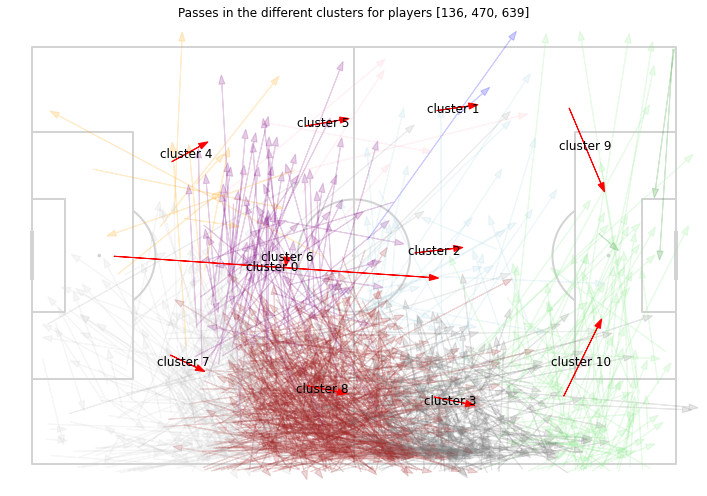

In [31]:
fig, ax = pitch.draw(figsize=(11, 7))

plt.gca().invert_yaxis()

# We filter the players that result in having a high number of passes that belong to cluster 8,
# which we identified in the earlier cell
player_ids = [136, 470, 639]
df_plot = df[(df.player_id.isin(player_ids))]

for idx, center in enumerate(clustering.cluster_centers_):
    ax.text(
        center[0] + (center[2] - center[0]) / 2,
        center[1] + (center[3] - center[1]) / 2,
        s=f'cluster {idx}',
        zorder=5,
        ha='center',
        va='center',
        fontsize=12
    )
    arrow = ax.arrow(center[0], center[1], center[2] - center[0], center[3] - center[1], color='red', head_width=1, zorder=4)

cluster_colors = [
    'darkgray', 'blue', 'lightblue', 'gray', 'orange', 'pink', 'purple', 'lightgray', 'brown', 'green', 'lightgreen'
]

for idx, row in df_plot.iterrows():
    color = cluster_colors[int(row.cluster)]
    arrow = ax.arrow(
        row.x, row.y, row.endx - row.x, row.endy - row.y, color=color, alpha=0.1, head_width=1, zorder=1
    )
    ax.add_patch(arrow)

ax.set_title(f'Passes in the different clusters for players {player_ids}')

# These are the players that have mainly passes in cluster 8 as shown in the Figure

Above we have the plot with the passes of the players that have the most passes that are categorized in cluster 8. Here we see that cluster 8 has a high number of passes on the right side of the pitch, which would let us suggest that this cluster characterizes players playing as right fullbacks. Moreover, we also see that these players have also several crosses towards the opposite box.

In this case, an issue for this kind of analysis is that having passed for several games, it happens that a player may change the role and hence play differently, contributing to the game with different kinds of passes. That is also why I decided to go with this approach of 11 clusters instead of much more clusters because I did not have information about the player roles and hence tailoring much more the clustering to the use case.

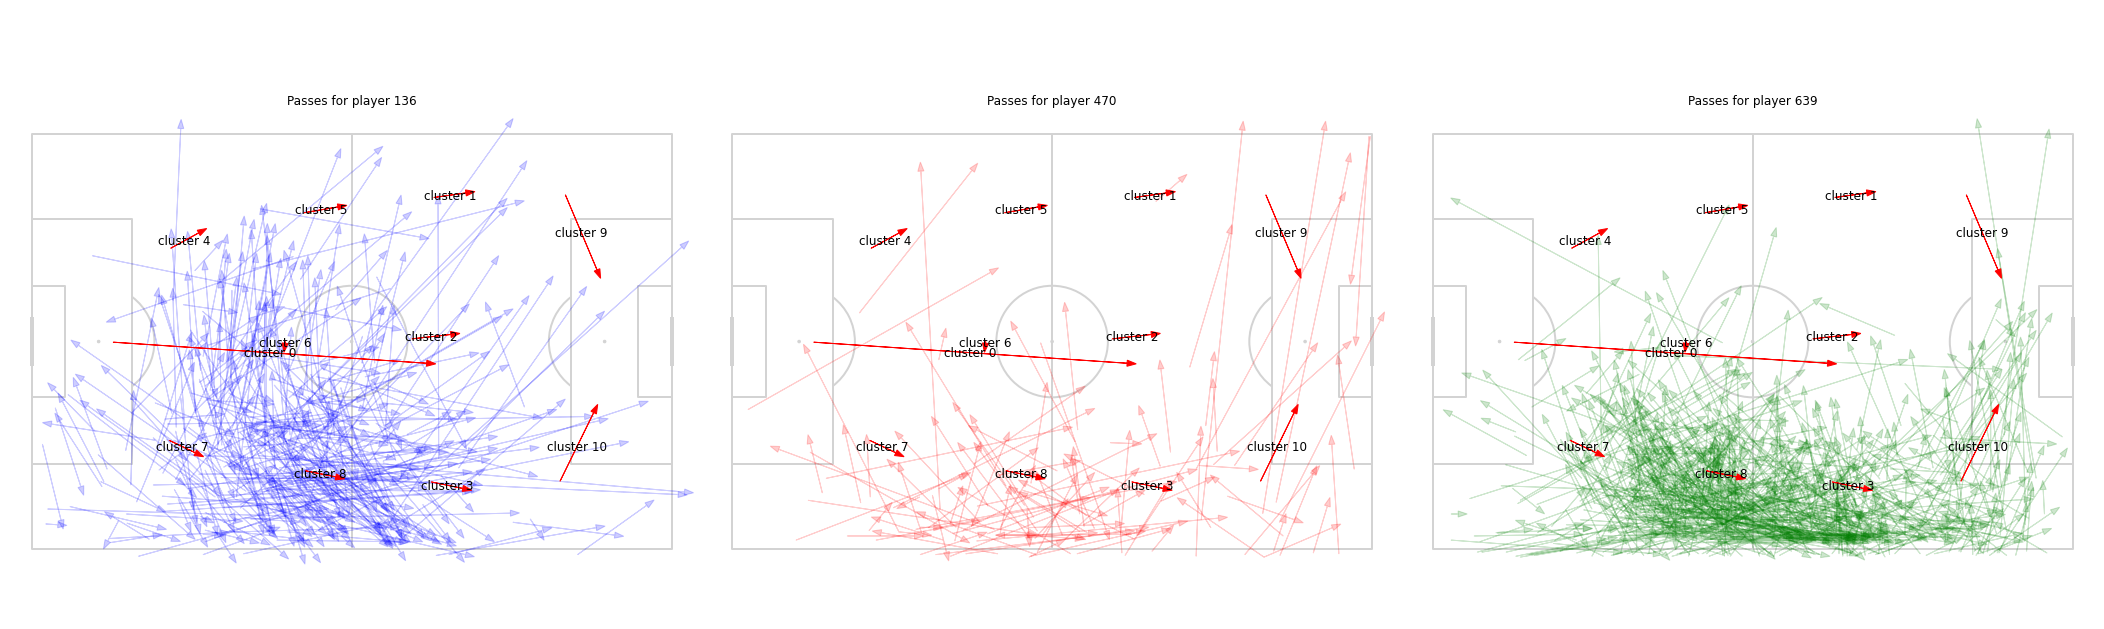

In [32]:
fig, ax = pitch.grid(nrows=1, ncols=3, axis=False)

# plt.gca().invert_yaxis()

player_colors = [
    'blue', 'red', 'green'
]

for idx, player_id in enumerate(player_ids):
    for cluster_idx, center in enumerate(clustering.cluster_centers_):
        ax['pitch'][idx].text(
            center[0] + (center[2] - center[0]) / 2,
            center[1] + (center[3] - center[1]) / 2,
            s=f'cluster {cluster_idx}',
            zorder=5,
            ha='center',
            va='center',
            fontsize=12
        )
        arrow = ax['pitch'][idx].arrow(center[0], center[1], center[2] - center[0], center[3] - center[1], color='red', head_width=1, zorder=4)

    for _, row in df_plot[df_plot.player_id == player_id].iterrows():
        color = player_colors[player_ids.index(int(row.player_id))]
        arrow = ax['pitch'][idx].arrow(
            row.x, row.y, row.endx - row.x, row.endy - row.y, color=color, alpha=0.1, head_width=1, zorder=1
        )
        ax['pitch'][idx].add_patch(arrow)
    ax['pitch'][idx].set_title(f'Passes for player {player_id}')
    ax['pitch'][idx].invert_yaxis()

Here above we see the passes of the players with mainly passes categorized as type 8, which have similar passes, even if it may be that played in different roles. The player in green seems to be a right full-back, the same can be said about the player in red. For what concerns the player in blue, it seems more a center back, or a full-back that has mainly a defensive attitude and duty.

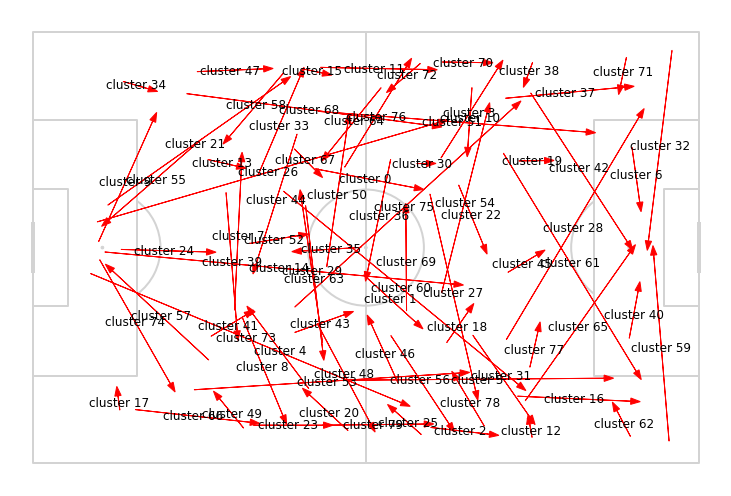

In [33]:
# For a more fine grained analysis, we can select a higher number of clusters, e.g., 80

cl = KMeans(n_clusters=80).fit(X[['x', 'y', 'endx', 'endy']])
c = cl.predict(X[['x', 'y', 'endx', 'endy']])
fig, ax = pitch.draw(figsize=(11, 7))

plt.gca().invert_yaxis()

for idx, center in enumerate(cl.cluster_centers_):
    ax.text(
        center[0] + (center[2] - center[0]) / 2,
        center[1] + (center[3] - center[1]) / 2,
        s=f'cluster {idx}',
        zorder=5,
        ha='center',
        va='center',
        fontsize=12
    )
    arrow = ax.arrow(center[0], center[1], center[2] - center[0], center[3] - center[1], color='red', head_width=1, zorder=4)

From the plot above, we see much many patterns of course. This would allow for a fine-grained analysis of players that play similar passes. Moreover, it is nice to see that the pitch has very similar clusters on both the left and right sides. This may allow us to make further analyses by considering only half of the pitch.

Of course, the correct number of clusters has to be identified through the Elbow method, the Silhouette coefficient, or another metric that displays which k gives the best results.

### Conclusions

The question was to create a model that predicts the probability of a pass being completed and to assess the players passing skills.

First, I read the dataset and cleaned it. To mock this step, I removed the rows with null values and removed the passes that ended in a position out of the field, which is not allowed by the football rules (I was a referee and I confirm that).

Then, I did some analysis over the data, by plotting the main information regarding the different fields of the dataset (passes that are throw-ins, goalkeeper throws, corners, crosses, ...) and adding new columns (length of the pass and angle for a forward pass). For the new columns that I added, I run some analysis to see the variations of the success probability for the length of the pass and the pass angle, which lead to an inverse probability for what concerns the pass length concerning the pass success rate and instead of a monotonic probability for what concerns the angle. In both cases, the relationship could be summarized in a Sigmoid function with parameters that have to be further investigated. Just by using the given features and those I computed (which are pass length and pass angle), hence, without a feature selection process, I run several classification models to classify a pass as a pass that should have been completed or not. I used cross-validation, to avoid selection bias and AUC as a metric for evaluating the algorithms. I found that the most efficient algorithm was XGBoost Classifier, hence I applied it over the whole dataset. I checked which are the most useful features, an analysis that would have to lead me to tune again the algorithm, probably using only the pass length, the end y coordinate, and the pass angle as features. Ideally, it would have been better to remove the throw-in passes, since they are a peculiar kind of passes, and I would have considered the sequences of passes that would have lead to a shot (or goal) or those that are also an assist. Moreover, even the sequences of consecutive passes that let a team establish the possession are something that could have been added. Hence, having the data of the shots, tackles, and the other events of the match would have helped and could have been added to the model. After having run the model over the whole dataset, I was able to show the expected pass rate for the pitch position and its difference from the actual passes that were completed, both for the starting and ending nodes.

Then, to identify the best passers, I first used some statistical measurements that compare different kinds of player skills. On the other side, I used clustering to group players, by running the algorithm with different numbers of clusters. For k=11, by clustering the passes, I tried to identify and group the players by role position. For a more informative clustering, I would have had to use more clusters as I showed with k=80. Any information that would have helped would have been the player position in each game, to further reduce the investigation only to players that play in the same way the same role. Anyway, the clustering I adopted helped in identifying the players that for the majority used passes that belong to the same cluster, hence finding the players that often use the same pass type. In addition, another step in the process would have been, as I already mentioned above, to z-normalize the passes within a cluster, to have more standardized results, and highlight the passing "expertise" of the players.

To summarize, the extra information needed would have been:
- role positions of the players
- event data for the whole match
- more information about what we are looking for (for finding similar players)
- KPI metrics for defining the best player